# Faire un métamodèle de krigeage


## Le krigeage dans OpenTURNS

### Le modèle de déviation de la poutre encastrée

Dans l'exemple qui suit, on considère le modèle de déviation de la poutre encastrée. Dans ce modèle, on considère 4 variables aléatoires liées par une copule Gaussienne. 

<img src="poutre.png" width="300px">

On considère 4 variables aléatoires :
 - E : le module d'Young [Pa]
 - F : la force appliquée [N]
 - L : la longueur [m]
 - I : le moment d'inertie de la poutre [m^4]

La déviation verticale de la poutre sous l'effet de la force appliquée est modélisée par l'équation :
$$
y = \frac{FL^3}{3EI}
$$

On considère les lois de probabilité suivantes :

- E ~ Beta(0.93, 3.2, 2.8e7, 4.8e7)
- F ~ LogNormal(30000, 9000, 15000)
- L ~ Uniform(250, 260)
- I ~ Beta(2.5, 4.0, 3.1e2, 4.5e2)
 
On fait l'hypothèse que les variables aléatoires E, F, L et I sont liées par une copule Gaussienne dont la matrice de corrélation est :
$$
R = 
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & -0.2 \\
0 & 0 & -0.2 & 1
\end{pmatrix}
$$

En d'autres termes, on considère que les variables L et I sont corrélées négativement : lorsque la longueur L augmente, le moment d'inertie I diminue. 

On créé un méta-modèle de krigeage fondé sur un modèle exponentiel carré. Pour estimer le métamodèle, nous allons utiliser un plan d'expériences de taille 20. 

### Définition du modèle

In [1]:
import openturns as ot

Etape A : définition du modèle. Nous commençons par définir une fonction symbolique qui évalue la sortie y en fonction des entrées E, F, L et I.

In [2]:
model = ot.SymbolicFunction(["E", "F", "L", "I"], ["F*L^3/(3*E*I)"])

Etape B : définition des distributions du vecteur aléatoire en entrée. Nous définissons ensuite les lois de distribution des variables aléatoires E, F, L et I.

In [3]:
# Young's modulus E: beta distribution
E = ot.Beta(0.9, 3.5, 2.5e7, 5.0e7) # in N/m^2
E.setDescription("E")
# Load F: lognormal distribution
F = ot.LogNormal() # in N
F.setParameter(ot.LogNormalMuSigma()([3e4, 9e3, 0.]))
F.setDescription("F")
# Length L: uniform distribution
L = ot.Uniform(2.5, 2.6) # in m
L.setDescription("L")
# Moment of inertia I: beta distribution
I = ot.Beta(2.5, 4, 3.1e2, 4.5e2) # in m^4
I.setDescription("I")

Puis on définit la dépendance entre les variables d'entrée en créant une copule Gaussienne avec la classe `NormalCopula`.

In [4]:
dim = 4 # number of inputs
R = ot.CorrelationMatrix(dim)
R[2, 3] = -0.2 
myCopula = ot.NormalCopula(ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(R))
myDistribution = ot.ComposedDistribution([E, F, L, I], myCopula)

### Définition d'un plan d'expériences

Nous considérons un plan d'expériences de type Monte-Carlo simple. Pour cela, on génère un échantillon des entrées grâce à la méthode `getSample`. Puis nous évaluons la sortie en appelant la fonction `model`.

In [5]:
sampleSize_train = 20
X_train = myDistribution.getSample(sampleSize_train)
Y_train = model(X_train)

Observons la distribution des déviations verticales Y sur la base d'apprentissage. On observe que les déviations plus grandes sont moins fréquentes. 

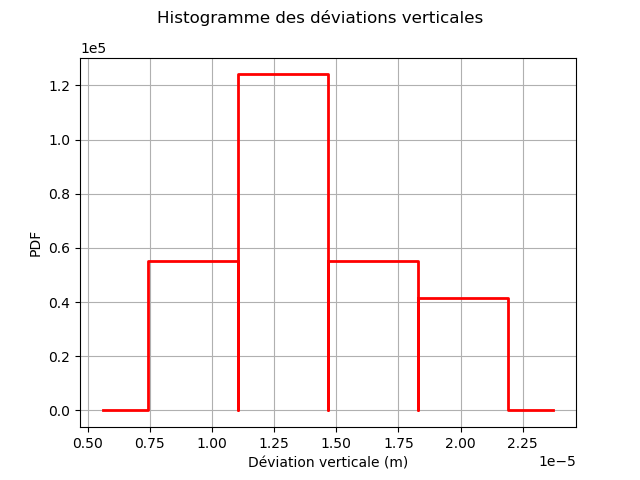

In [6]:
histo = ot.HistogramFactory().build(Y_train).drawPDF()
histo.setXTitle("Déviation verticale (m)")
histo.setTitle("Histogramme des déviations verticales")
histo.setLegends([""])
histo

### Création du méta-modèle

Pour créer le krigeage, on choisit une tendance constante avec la classe `ConstantBasisFactory`. Puis on utilise un modèle de covariance de type exponentielle carrée. Enfin, on utilise la classe `KrigingAlgorithm` pour créer le krigeage en utilisant la base d'apprentissage, le modèle de covariance et la tendance.

In [7]:
dimension = myDistribution.getDimension()
basis = ot.ConstantBasisFactory(dimension).build()
covarianceModel = ot.SquaredExponential([1.]*dimension, [1.0])
algo = ot.KrigingAlgorithm(X_train, Y_train, covarianceModel, basis)
algo.run()
result = algo.getResult()
krigeageMM = result.getMetaModel()

La méthode `run` a évalué les paramètres du modèle par la méthode du maximum de vraisemblance. 

On peut alors afficher la tendance constante du modèle.

In [8]:
result.getTrendCoefficients()

[class=Point name=Unnamed dimension=1 values=[2.08572e-05]]

On peut également afficher les paramètres du modèle de covariance, estimés par la méthode du maximum de vraisemblance.

In [9]:
result.getCovarianceModel()

class=SquaredExponential scale=class=Point name=Unnamed dimension=4 values=[6.10212,5.22704,7.19611,6.89181] amplitude=class=Point name=Unnamed dimension=1 values=[9.19034e-06]

On souhaite ensuite valider le métamodèle de krigeage. Pour cela, on génère un échantillon de validation de taille 100 et on évalue la sortie du modèle sur cet échantillon.

In [10]:
sampleSize_test = 100
X_test = myDistribution.getSample(sampleSize_test)
Y_test = model(X_test)

Sur l'échantillon de validation, on évalue les sorties du méta-modèle.

In [11]:
Y_test_MM = krigeageMM(X_test)

La classe `MetaModelValidation` facilite le travail de validation d'un métamodèle. Pour la constuire, on lui donne les entrées de la base de validation, les sorties correspondantes et le métamodèle.

In [12]:
val = ot.MetaModelValidation(X_test, Y_test, krigeageMM)

La méthode `computePredictivityFactor` permet d'estimer le coefficient $Q_2$.

In [13]:
val.computePredictivityFactor()

0.9830432762889807

Puisque le $Q_2$ est supérieur à 0.95, on peut dire que c'est un très bon méta-modèle.

Il est intéressant de dessiner l'histogramme des résidus : on peut le faire avec la classe `HistogramFactory` appliquée à l'échantillon des résidus `r`. 

On observe que les résidus négatifs sont presque aussi fréquents que les résidus positifs : c'est plutôt un signe positif pour la qualité du métamodèle. Dans notre cas, la déviation verticale est plutôt petite, de l'ordre de $10^{-5}$. Cela implique qu'il n'est pas si simple de voir si, en valeur absolue, les résidus sont plutôt petits, ou non : le graphique que nous dessinerons par la suite est plus fiable de ce point de vue.

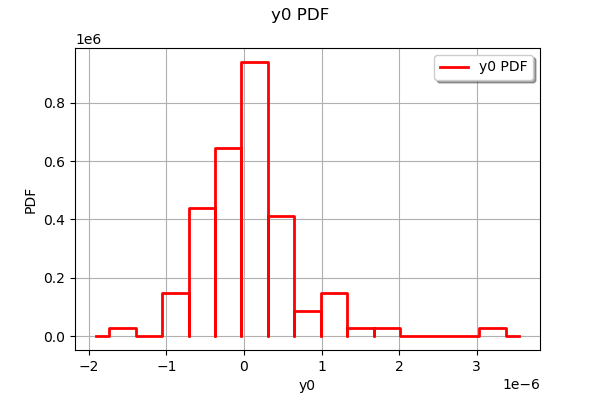

In [14]:
r = val.getResidualSample()
ot.HistogramFactory().build(r).drawPDF()

La méthode `drawValidation` permet de comparer les données observées et les prédictions du méta-modèle. 

On observe que les croix rouges sont à proximité de la première bissectrice : cela montre que le méta-modèle est plutôt de bonne qualité. Toutefois, pour les grandes déviations, les points rouges sont plus éloignées de la première bissectrice : le métamodèle est moins bon pour les grandes déviations.

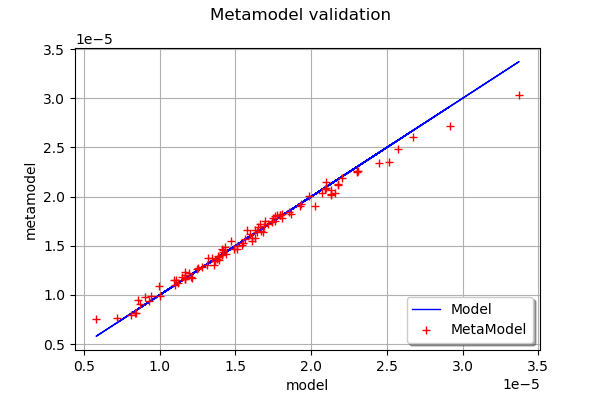

In [15]:
val.drawValidation()

## Annexe : coefficient de prédictivité

Le facteur de prédictivité $Q_2$ est un coefficient qui mesure la qualité d'un méta-modèle. 
* C'est un nombre entre 0 et 1.
* Si Q2 est proche de 1, alors le métamodèle est excellent.
* Si Q2 est proche de 0, alors le métamodèle est une mauvaise approximation de la fonction.

En pratique, un $Q_2$ supérieur à 0.95 est qualifié de satisfaisant. 

On suppose que l'on dispose de $n$ entrées de validation $\boldsymbol{x}_i$ ainsi que des observations $y_i$ correspondantes. On note $M$ le méta-modèle. 
Soit $\bar{y}$ la moyenne des observations de validation :
$$
\bar{y} = \frac{1}{n} \sum_{i=1}^{n} y_i
$$
Le coefficient $Q_2$ est défini par l'équation :
$$
Q_2 = 1 - \frac{\sum_{i=1}^{n} (y_i - M(\boldsymbol{x}_i))^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}.
$$

## Exercices

### Exercice 1 : sensibilité à la taille de l'échantillon d'apprentissage

On s'interroge sur l'évolution de la qualité du métamodèle lorsque le nombre de points dans le plan d'expériences augmente. 

**Questions**
* Modifier le plan d'expériences utilisé pour apprendre le méta-modèle : utiliser `sampleSize_train = 100`. 
* Mettre à jour le métamodèle de krigeage. 
* Comment évolue le coefficient de prédictivité ?
* Pourquoi ?

### Solution de l'exercice 1 : sensibilité à la taille de l'échantillon d'apprentissage

In [16]:
sampleSize_train = 100
X_train = myDistribution.getSample(sampleSize_train)
Y_train = model(X_train)

In [17]:
dimension = myDistribution.getDimension()
basis = ot.ConstantBasisFactory(dimension).build()
covarianceModel = ot.SquaredExponential([1.]*dimension, [1.0])
algo = ot.KrigingAlgorithm(X_train, Y_train, covarianceModel, basis)
algo.run()
result = algo.getResult()
krigeageMM = result.getMetaModel()

In [18]:
sampleSize_test = 100
X_test = myDistribution.getSample(sampleSize_test)
Y_test = model(X_test)

In [19]:
val = ot.MetaModelValidation(X_test, Y_test, krigeageMM)
val.computePredictivityFactor()

0.9999891546322435

On observe que le coefficient de prédictivité est excellent : le métamodèle avec 100 points est de très bonne qualité.

### Exercice 2 : utilisation d'une tendance

Il y a trois classes qui permettent de créer des modèles de tendance.
* `ConstantBasisFactory` : tendance constante
* `LinearBasisFactory` : tendance linéaire
* `QuadraticBasisFactory` : tendance quadratique

**Questions**
* Mettre à jour la tendance du modèle et utiliser une tendance linéaire. 
* Quelle est la tendance estimée par la méthode du maximum de vraisemblance ?
* Quel est l'impact sur la qualité du méta-modèle ?

### Solution de l'exercice 2 : utilisation d'une tendance

In [20]:
sampleSize_train = 20
X_train = myDistribution.getSample(sampleSize_train)
Y_train = model(X_train)

In [21]:
dimension = myDistribution.getDimension()
basis = ot.LinearBasisFactory(dimension).build()
covarianceModel = ot.SquaredExponential([1.]*dimension, [1.0])
algo = ot.KrigingAlgorithm(X_train, Y_train, covarianceModel, basis)
algo.run()
result = algo.getResult()
krigeageMM = result.getMetaModel()

In [22]:
trendCoefficients = result.getTrendCoefficients()
constantTrend = trendCoefficients[0]
constantTrend

class=Point name=Unnamed dimension=5 values=[1.67049e-05,-2.19781e-06,5.24488e-06,6.07475e-07,-1.1179e-06]

In [23]:
sampleSize_test = 100
X_test = myDistribution.getSample(sampleSize_test)
Y_test = model(X_test)

In [24]:
val = ot.MetaModelValidation(X_test, Y_test, krigeageMM)
val.computePredictivityFactor()

0.9923352167604278

On observe que le Q2 vaut désormais 0.992 au lieu de 0.976 précédemment. Cela montre que prendre en compte une tendance linéaire a permis d'améliorer un peu la qualité du métamodèle.

### Exercice 3 : distribution des résidus

On souhaite valider la qualité du métamodèle. Nous avons vu comment récupérer les résidus avec la classe `getResidualSample` et tracer l'histogramme de ces résidus avec la classe `HistogramFactory`. Il s'avère que l'on peut récupérer directement la distribution des résidus avec la méthode `getResidualDistribution`.

**Questions**
* Utiliser la méthode `getResidualDistribution` pour obtenir la distribution des résidus.
* Utiliser la méthode `drawPDF` pour dessiner la distribution des résidus.
* Que conclure ?

### Solution de l'exercice 3 : distribution des résidus

In [25]:
val = ot.MetaModelValidation(X_test, Y_test, krigeageMM)

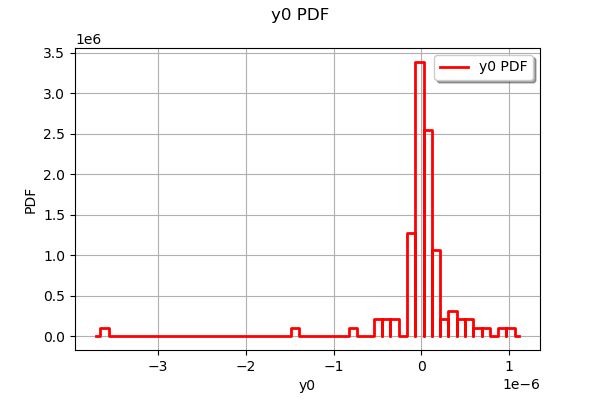

In [26]:
hist = val.getResidualDistribution(False)
hist.drawPDF()

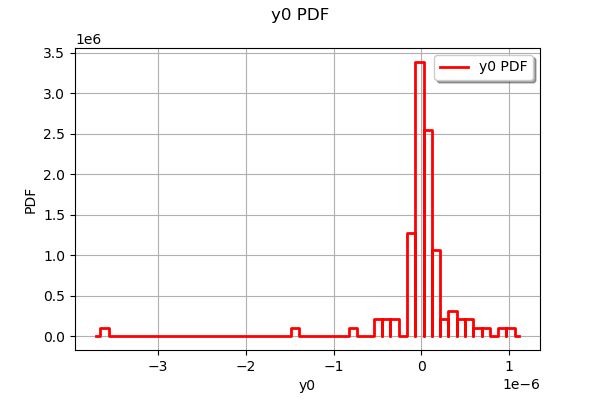

In [27]:
r = val.getResidualSample()
ot.HistogramFactory().build(r).drawPDF()

On observe que les deux graphiques sont identiques : les deux méthodes sont strictement équivalentes.

### Exercice 4

**Questions**
* Créer le processus qui modélise l'incertitude sur $y$ (classe ConditionedGaussianProcess) sur un maillage d'une seule maille.
* A quoi peuvent servir les instructions suivantes ? Les tester.

```
# LHS design
############

K = 25 # design size
bounds = algo.getOptimizationBounds()
lbounds = bounds.getLowerBound()
ubounds = bounds.getUpperBound()
distributions = ot.DistributionCollection()
for i in range(d):
    distributions.add(ot.Uniform(lbounds[i], ubounds[i]))

def _exec(point):
    return [distributions[i].computeQuantile(point[i])[0] for i in range(d)]

transform = ot.PythonFunction(d, d, _exec)
LHS = ot.LHSExperiment(ot.ComposedDistribution([ot.Uniform(0.0, 1.0)]*d), K)
LHS.setAlwaysShuffle(True)
SA_profile = ot.GeometricProfile(10., 0.95, 20000)
LHS_optimization_algo = ot.SimulatedAnnealingLHS(LHS, SA_profile, ot.SpaceFillingC2())
LHS_optimization_algo.generate()
LHS_design = LHS_optimization_algo.getResult()
LHS_design = LHS_design.getOptimalDesign()
starting_points = transform(LHS_design)

# Change of the kriging algorithm
multiStartSolver = ot.MultiStart(solver, starting_points)
algo.setOptimizationAlgorithm(multiStartSolver)
algo.run()
```

### Solution de l'exercice 4

In [28]:
q5 = [E.computeQuantile(0.05)[0], F.computeQuantile(0.05)[0], L.computeQuantile(0.05)[0], I.computeQuantile(0.05)[0]]
q95 = [E.computeQuantile(0.95)[0], F.computeQuantile(0.95)[0], L.computeQuantile(0.95)[0], I.computeQuantile(0.95)[0]]
vertices = [q5, [q5[0], q5[1], q5[2], q95[3]], [q5[0], q5[1], q95[2], q95[3]], [q5[0], q95[1], q95[2], q95[3]] ,q95]
simplices = [[0, 1, 2, 3, 4]]
mesh = ot.Mesh(vertices, simplices)
conditionedGP = ot.ConditionedGaussianProcess(result, mesh)

Le processsu obtenu peut être utilisé pour simuler un grand nombre de trajectoires possibles, par exemple.

2e question : les lignes proposées permettent de tester la robustesse de l'optimisation de la vraisemblance lors de l'estimation des paramètres de la fonction de covariance. L'idée est de lancer l'algorithme d'optimisation, dont le déroulement dépend du point choisi pour initier l'optimisation, à partir de différents points, aussi bien répartis que possible (utilisation d'un LHS optimisé).

In [29]:
solver = algo.getOptimizationAlgorithm()

# LHS design
K = 25 # design size
bounds = algo.getOptimizationBounds()
lbounds = bounds.getLowerBound()
ubounds = bounds.getUpperBound()
distributions = ot.DistributionCollection()
for i in range(dim):
    distributions.add(ot.Uniform(lbounds[i], ubounds[i]))

def _exec(point):
    return [distributions[i].computeQuantile(point[i])[0] for i in range(dim)]

transform = ot.PythonFunction(dim, dim, _exec)
LHS = ot.LHSExperiment(ot.ComposedDistribution([ot.Uniform(0.0, 1.0)]*dim), K)
LHS.setAlwaysShuffle(True)
SA_profile = ot.GeometricProfile(10., 0.95, 20000)
LHS_optimization_algo = ot.SimulatedAnnealingLHS(LHS, SA_profile, ot.SpaceFillingC2())
LHS_optimization_algo.generate()
LHS_design = LHS_optimization_algo.getResult()
LHS_design = LHS_design.getOptimalDesign()
starting_points = transform(LHS_design)

# Change of the kriging algorithm
solver.setMaximumIterationNumber(10000)
multiStartSolver = ot.MultiStart(solver, starting_points)
algo.setOptimizationAlgorithm(multiStartSolver)
algo.run()

In [30]:
print(result.getCovarianceModel().getParameter())
new_result = algo.getResult()
print(new_result.getCovarianceModel().getParameter())

[1.82942,2.13637,5.97875,5.29203]
[1.82964,2.13638,5.97875,5.29202]


On observe que l'optimisation, donc le résultat du krigeage, est sensible au point initial.